In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session # to clear keras session
from tensorflow.keras.models import Sequential # to build sequential model
from tensorflow.keras.layers import Dense, Dropout # different keras layers
from tensorflow.keras.utils import to_categorical # to convert output to categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist # to load MNIST dataset
from tensorflow.keras.models import load_model # load keras model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau # keras callbacks

In [3]:
import pandas as pd
from os import getcwd
from sys import path
from matplotlib import pyplot as plt
import numpy as np
from functools import partial

In [4]:
PROJECT_PATH = getcwd()[:getcwd().find("notebooks")][:-1]
MODEL_PATH = f"{PROJECT_PATH}\\models"
path.append(f"{PROJECT_PATH}\\src")

In [5]:
from plot_losses import PlotLosses

In [6]:
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

In [7]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(f"Found {X_train.shape[0]} training and {X_test.shape[0]} testing data points")

Found 60000 training and 10000 testing data points


Digit: 4


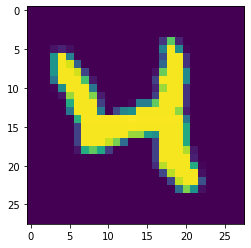

In [8]:
i = 20
print("Digit: %d"% Y_train[i])
plt.imshow(X_train[i])

In [9]:
X_train.shape

(60000, 28, 28)

In [10]:
# Reshape data
HEIGHT = X_train.shape[1]
WIDTH = X_train.shape[2]
NUM_CLASSES = len(np.unique(Y_train))

print(f"Height: {HEIGHT} and Width: {HEIGHT}")
print(f"Unique number of digits: {NUM_CLASSES}")

Height: 28 and Width: 28
Unique number of digits: 10


In [11]:
def preprocess_data(data : np.ndarray):
    """Flatten and normalize data."""
    data = data.reshape((data.shape[0], np.prod(data.shape[1:]))) # flattening data
    return data / 255.0 # normalizing values

In [12]:
def generate_categories(data : np.ndarray, 
                        n_categories : int):
    """Generate one hot encoded categories for each class."""
    return to_categorical(data, num_classes = n_categories)

In [13]:
X_train = preprocess_data(X_train)
Y_train = generate_categories(Y_train, NUM_CLASSES)

X_test = preprocess_data(X_test)
Y_test = generate_categories(Y_test, NUM_CLASSES) 

In [14]:
print(f"After preprocessing, input data shape: {X_train.shape}")
print(f"After generating categories, output data shape: {Y_train.shape}")

After preprocessing, input data shape: (60000, 784)
After generating categories, output data shape: (60000, 10)


In [15]:
clear_session() # clear keras backend session
model = Sequential()
model.add(Dense(units=32, activation='relu', input_shape=(HEIGHT*WIDTH, )))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(NUM_CLASSES, activation='softmax'))

optimizer = Adam() 

model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


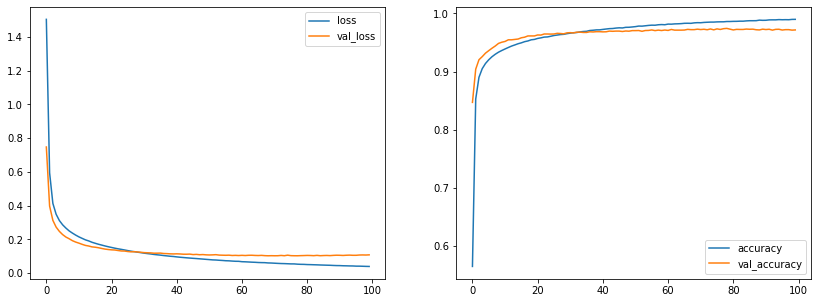

54000/54000 [==============================] - 1s 18us/sample - loss: 0.0401 - accuracy: 0.9899 - val_loss: 0.1088 - val_accuracy: 0.9717


In [16]:
BATCH_SIZE = 1280
EPOCHS = 100
model_history = model.fit(x = X_train, y = Y_train, 
                          callbacks = [PlotLosses()],
                          batch_size = BATCH_SIZE, 
                          epochs = EPOCHS, 
                          validation_split = .1, 
                          shuffle = True)

In [17]:
MODEL_NAME = "MNIST_DNN"
model.save(f"{MODEL_PATH}\\{MODEL_NAME}.h5")

In [18]:
model = load_model(f"{MODEL_PATH}\\{MODEL_NAME}.h5") # loading the keras model

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


# Understanding Early Stopping

In [20]:
# to stop model if val loss not decreasing
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = .0005,  
                               verbose = 1, 
                               mode = 'auto',
                               baseline = None, 
                               restore_best_weights = True)

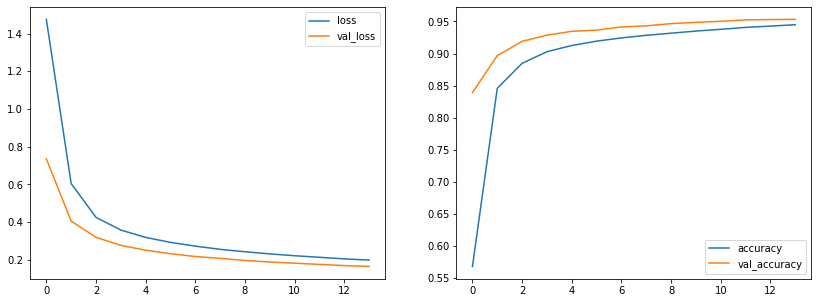

Restoring model weights from the end of the best epoch.
54000/54000 [==============================] - 1s 19us/sample - loss: 0.1993 - accuracy: 0.9449 - val_loss: 0.1654 - val_accuracy: 0.9533
Epoch 00014: early stopping


In [21]:
clear_session() # clear keras backend session
model = Sequential()
model.add(Dense(units = 32, activation='relu', input_shape=(HEIGHT*WIDTH, )))
model.add(Dense(NUM_CLASSES, activation='softmax'))

optimizer = Adam() 

model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

BATCH_SIZE = 1280
EPOCHS = 100
model_history = model.fit(x = X_train, y = Y_train, 
                          callbacks = [PlotLosses(), early_stopping],
                          batch_size = BATCH_SIZE, 
                          epochs = EPOCHS, 
                          validation_split = .1, 
                          shuffle = True)

In [22]:
val_accuracies = model_history.history['val_accuracy']
for i in range(len(val_accuracies)-1):
    print(f"val_accuracy increase {i} -> {i+1} : {val_accuracies[i+1] - val_accuracies[i]:.4f}")

val_accuracy increase 0 -> 1 : 0.0577
val_accuracy increase 1 -> 2 : 0.0223
val_accuracy increase 2 -> 3 : 0.0097
val_accuracy increase 3 -> 4 : 0.0060
val_accuracy increase 4 -> 5 : 0.0018
val_accuracy increase 5 -> 6 : 0.0050
val_accuracy increase 6 -> 7 : 0.0017
val_accuracy increase 7 -> 8 : 0.0035
val_accuracy increase 8 -> 9 : 0.0020
val_accuracy increase 9 -> 10 : 0.0017
val_accuracy increase 10 -> 11 : 0.0022
val_accuracy increase 11 -> 12 : 0.0005
val_accuracy increase 12 -> 13 : 0.0003


Early stopping condition stopped training when accuracy does not increase by minimum threshold

In [23]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20079304424524308
Test accuracy: 0.9447


# Understanding Learning Scheduler

In [24]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.math.exp(-0.1)

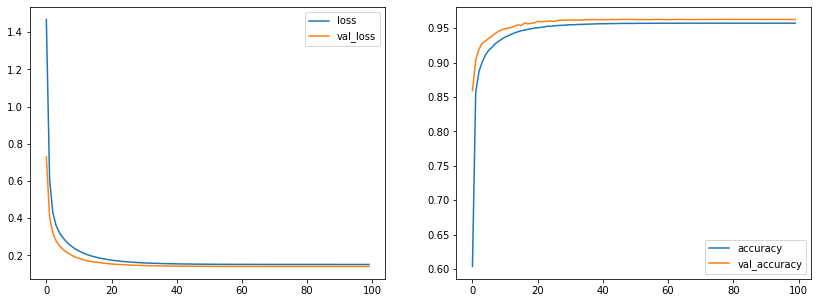

54000/54000 [==============================] - 1s 22us/sample - loss: 0.1515 - accuracy: 0.9573 - val_loss: 0.1408 - val_accuracy: 0.9627


In [25]:
clear_session() # clear keras backend session
model = Sequential()
model.add(Dense(units = 32, activation='relu', input_shape=(HEIGHT*WIDTH, )))
model.add(Dense(NUM_CLASSES, activation='softmax'))

optimizer = Adam() 

model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

BATCH_SIZE = 1280
EPOCHS = 100
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

model_history = model.fit(x = X_train, y = Y_train, 
                          callbacks = [PlotLosses(), lr_scheduler],
                          batch_size = BATCH_SIZE, 
                          epochs = EPOCHS, 
                          validation_split = .1, 
                          shuffle = True)

Text(0, 0.5, 'lr')

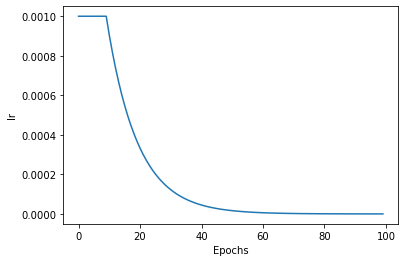

In [26]:
lr_init = .001
lr_epochs = [lr_init]
for i in range(1, EPOCHS):
    lr_epochs.append(scheduler(i, lr_epochs[i-1]))
fig, ax = plt.subplots()
ax.plot(lr_epochs)
ax.set_xlabel("Epochs")
ax.set_ylabel("lr")

In [27]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16621162532940506
Test accuracy: 0.9525


# Understanding ReduceLROnPlateau

In [28]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.9,
                              patience = 10,
                              mode = "auto",
                              min_delta = .01, 
                              restore_best_weights = True)

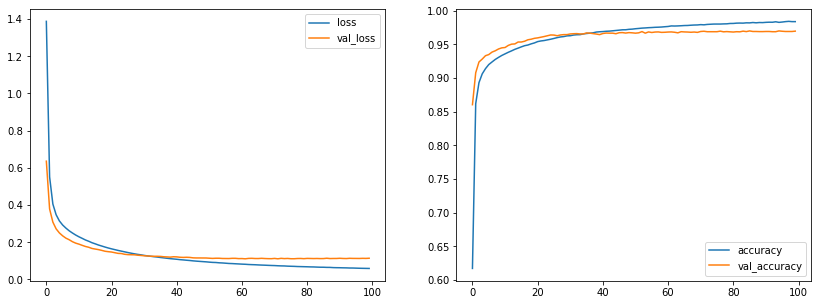

54000/54000 [==============================] - 1s 18us/sample - loss: 0.0591 - accuracy: 0.9840 - val_loss: 0.1140 - val_accuracy: 0.9698


In [29]:
clear_session() # clear keras backend session
model = Sequential()
model.add(Dense(units = 32, activation='relu', input_shape=(HEIGHT*WIDTH, )))
model.add(Dense(NUM_CLASSES, activation='softmax'))

optimizer = Adam() 

model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

BATCH_SIZE = 1280
EPOCHS = 100
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

model_history = model.fit(x = X_train, y = Y_train, 
                          callbacks = [PlotLosses(), reduce_lr],
                          batch_size = BATCH_SIZE, 
                          epochs = EPOCHS, 
                          validation_split = .1, 
                          shuffle = True)

Text(0, 0.5, 'lr')

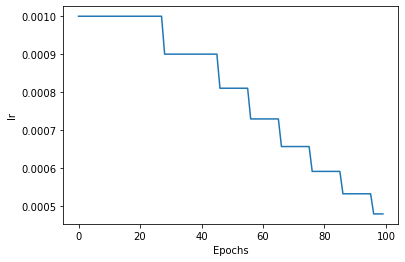

In [30]:
fig, ax = plt.subplots()
ax.plot(model_history.history["lr"])
ax.set_xlabel("Epochs")
ax.set_ylabel("lr")

In [31]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11854441162860022
Test accuracy: 0.9663


In [32]:
val_accuracies = model_history.history['val_accuracy']
for i in range(len(val_accuracies)-1):
    print(f"val_accuracy increase {i} -> {i+1} : {val_accuracies[i+1] - val_accuracies[i]:.4f}, lr : {model_history.history['lr'][i]}")

val_accuracy increase 0 -> 1 : 0.0475, lr : 0.0010000000474974513
val_accuracy increase 1 -> 2 : 0.0160, lr : 0.0010000000474974513
val_accuracy increase 2 -> 3 : 0.0043, lr : 0.0010000000474974513
val_accuracy increase 3 -> 4 : 0.0050, lr : 0.0010000000474974513
val_accuracy increase 4 -> 5 : 0.0017, lr : 0.0010000000474974513
val_accuracy increase 5 -> 6 : 0.0037, lr : 0.0010000000474974513
val_accuracy increase 6 -> 7 : 0.0020, lr : 0.0010000000474974513
val_accuracy increase 7 -> 8 : 0.0027, lr : 0.0010000000474974513
val_accuracy increase 8 -> 9 : 0.0017, lr : 0.0010000000474974513
val_accuracy increase 9 -> 10 : 0.0005, lr : 0.0010000000474974513
val_accuracy increase 10 -> 11 : 0.0032, lr : 0.0010000000474974513
val_accuracy increase 11 -> 12 : 0.0018, lr : 0.0010000000474974513
val_accuracy increase 12 -> 13 : 0.0003, lr : 0.0010000000474974513
val_accuracy increase 13 -> 14 : 0.0028, lr : 0.0010000000474974513
val_accuracy increase 14 -> 15 : 0.0000, lr : 0.0010000000474974513